In [65]:
# %pip install -U gymnasium
# %pip install -U gymnasium[classic-control]

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [106]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

## REINFORCE

In [ ]:
LR = 3e-4
GAMMA = 0.9
MAX_STEPS = 1000
N_HIDDEN = 32
EPS = torch.finfo(torch.float32).eps

In [ ]:
class Policy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

In [ ]:
policy = Policy(n_in=4, n_out=2).to(device)

In [113]:
def discount_rewards(rewards, gamma):
    '''
    Compute the discounted rewards backwards through time, e.g.
      r0 + gamma * (r1 + gamma * (r2 + gamma * (...)))
      [----------------------------------------------]
         ^         [---------------------------------]
         |           ^           [-------------------]
      discount[0]    |             ^           [-----]
                  discount[1]      |             ^
                                discount[2]      |
                                              discount[n]                                              
    '''
    reward = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        reward = r + gamma * reward
        discounted_rewards.append(reward)
    return torch.tensor(discounted_rewards[::-1]).to(device)

def train(model, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100):
    model = model.to(device)
    model.train()
    opt = optim.Adam(policy.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward pass
        for _ in range(MAX_STEPS):
            # this feel bad performance wise, 1 cycle GPU, 1 cycle CPU
            # it's too much context switching
            # how can I benchmark this in a notebook?
            actions = policy(torch.tensor(state).float().to(device))
            m = torch.distributions.Categorical(actions)
            action = m.sample()
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(m.log_prob(action))
            if done:
                break
        # backward pass
        losses = []
        discounted_rewards = discount_rewards(rewards, gamma)
        for log_prob, reward in zip(log_probs, discounted_rewards):
            losses.append(-log_prob * reward)
        loss = torch.stack(losses).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % log_every == 0:
            print(f'{epoch:5} {loss.item()}')
    model.eval()

train(policy, epochs=1000)

    0 140.72378540039062
  100 389.76593017578125
  200 562.3916015625
  300 1522.986083984375
  400 1174.462890625
  500 1487.4931640625
  600 782.4196166992188
  700 301.91668701171875
  800 1335.84375
  900 1174.96826171875


In [114]:
# save
# ----
# torch.save(policy.state_dict(), 'weights/cartpole-reinforce.pt')

# load
# ----
# m = Policy(n_in=4, n_out=2).to(device)
# m.load_state_dict(torch.load('weights/cartpole-reinforce.pt'))

Episode finished after 413 timesteps


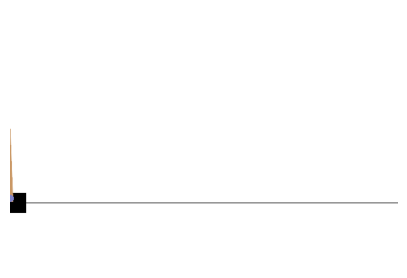

In [112]:
@torch.no_grad()
def show_play(env, policy, max_steps=MAX_STEPS):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('off')
    state, _ = env.reset()
    img = ax.imshow(env.render())
    for t in range(max_steps):
        actions = policy(torch.tensor(state).float().to(device))
        action = actions.argmax()
        state, _, done, _, _ = env.step(action.item())
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done:
            print("Episode finished after {} timesteps".format(t + 1))
            break

show_play(env, policy)

In [83]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch

@torch.no_grad()
def show_play(env, policy, max_steps=MAX_STEPS):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('off')
    state, _ = env.reset()

    def update(frame):
        actions = policy(torch.tensor(state).float().to(device))
        m = torch.distributions.Categorical(actions)
        action = m.sample()
        state, _, done, _, _ = env.step(action.item())
        ax.imshow(env.render(mode='rgb_array'))  # Ensure using rgb_array mode
        if done:
            print("Episode finished after {} timesteps".format(frame + 1))
            anim.event_source.stop()
    
    anim = FuncAnimation(fig, update, frames=max_steps, repeat=False)
    plt.close()  # Prevents duplicate display
    return HTML(anim.to_jshtml())  # Display as HTML

display(show_play(gym.make('CartPole-v1'), policy))


UnboundLocalError: cannot access local variable 'state' where it is not associated with a value

## A2C

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

actor = Actor(n_in=10, n_out=2)
critic = Critic(n_in=10)

In [ ]:
def train(epochs=100, lr=LR):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for epoch in range(epochs):
        state = env.reset()
        done = False

        while not done:
            action_probs = actor(torch.from_numpy(state).float())
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)

            V_current = critic(torch.from_numpy(state).float())
            V_next = critic(torch.from_numpy(next_state).float())

            # Compute advantage and TD-target
            advantage = reward + (1 - int(done)) * V_next - V_current
            td_target = reward + (1 - int(done)) * V_next

            # Update the critic
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

            # Update the actor
            actor_loss = -torch.log(action_probs[action]) * advantage.detach()
            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            state = next_state